Sales Forecast (not time series) + weather data updated

Start Modelling: Linear, Polynomial, XGBOOST, NEURAL NETWORKS, then need manipulate data (no sales duplicate data), then can do time series

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(r"C:\Users\chiaj\OneDrive\Desktop\FM Project\Master Weather + Store Subcluster + Holiday + Sales.csv")

# ───────────────────────────────────────────────────────────────────────────────
# 1) Preparing data for regression
# ───────────────────────────────────────────────────────────────────────────────
# List of categorical columns you want to encode
cat_cols = ['Store_No','Name', 'State', 'Day', 'CODE (subcluster 1)',
            'CODE FY26 1 (subcluster 2)', 'CODE FY26 2 (subcluster 3)', 'Rain?','Public Holiday']

# Fill missing values in these columns only
df[cat_cols] = df[cat_cols].fillna("Missing")

# Encode
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Making sure PH, Days from Holiday, Puasa count are all integers
object_cols = ["Public Holiday", "Days From Holiday","Puasa Count"]
for cols in object_cols:
    df[cols] = df[col].astype(int)

# Using a numeric placeholder instead of string
df[['Net_Amount', 'TC']] = df[['Net_Amount', 'TC']].replace("No Sales", 0).astype(float)

# Dropping datetime columns
df = df.drop(columns=['Date','Opening_Date'])  # if not useful

# Splitting into features and target
X = df.drop(['Net_Amount', 'TC'], axis=1)

C:\Users\chiaj\AppData\Local\Temp\ipykernel_13704\2450856943.py:4: DtypeWarning: Columns (2,3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\chiaj\OneDrive\Desktop\FM Project\Master Weather + Store Subcluster + Holiday + Sales.csv")


In [12]:
# ───────────────────────────────────────────────────────────────────────────────
# 2) Implementing Polynomial Regression
# ───────────────────────────────────────────────────────────────────────────────
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

y = df[['Net_Amount','TC']]

# Identify continuous columns
numeric_cols = [
    'Average Daily Temperature (°C)',
    'Days From Holiday',
    'Puasa Count',
    'Days_after_Opening'
]

# 2) Split before scaling so you don’t leak info
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3a) StandardScaler: center @0, std=1
std_scaler = StandardScaler()
X_train_std = X_train.copy()
X_test_std  = X_test.copy()

X_train_std[numeric_cols] = std_scaler.fit_transform( X_train[numeric_cols] )
X_test_std [numeric_cols] = std_scaler .transform( X_test [numeric_cols] )

# Creating a polynomial regression pipeline
degree = 2  # You can tune this
poly_model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
multi_model = MultiOutputRegressor(poly_model)

# Fit the model
multi_model.fit(X_train, y_train)

# Performance
y_pred = multi_model.predict(X_test)

for i, col in enumerate(y.columns):
    y_true = y_test.iloc[:, i]
    y_hat  = y_pred[:,    i]

    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    r2   = r2_score(             y_true, y_hat)      # ← define r2 here

    print(f"{col} → RMSE: {rmse:.2f} | R²: {r2:.3f}")


# my laptop can't run gridsearchcv cuz it takes too much memory
# multi_base = MultiOutputRegressor(base_pipeline)

# # 3) Define a neg‐RMSE scorer (so lower RMSE is “better” for GridSearch)
# rmse_scorer = make_scorer(
#     lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)),
#     greater_is_better=False
# )

# # 4) Parameter grid: tuning degree of polynomial (and intercept if you like)
# param_grid = {
#     'estimator__polynomialfeatures__degree':       [1, 2, 3, 4],
#     'estimator__linearregression__fit_intercept':  [True, False]
# }

# # 5) Set up GridSearchCV
# grid = GridSearchCV(
#     estimator = multi_base,
#     param_grid = param_grid,
#     scoring    = {'rmse': rmse_scorer, 'r2': 'r2'},
#     refit      = 'rmse',   # after CV, refit on whole train set using best RMSE
#     cv         = 5,
#     verbose    = 1,
#     n_jobs     = -1
# )

# # 6) Run grid search
# grid.fit(X_train, y_train)

# # 7) Evaluate best model on the test set
# best_model = grid.best_estimator_
# y_pred_gs  = best_model.predict(X_test)

# print("Best parameters:", grid.best_params_)
# print("\n=== Performance on TEST set ===")
# for i, col in enumerate(y.columns):
#     rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred_gs[:, i]))
#     r2   = r2_score(y_test.iloc[:, i],       y_pred_gs[:, i])
#     print(f"{col:12s} → RMSE: {rmse:8.2f} | R²: {r2:.3f}")

Net_Amount → RMSE: 3292.65 | R²: 0.092
TC → RMSE: 207.54 | R²: 0.213


In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 3) XGBOOST Regressor for Net_Amount
# ───────────────────────────────────────────────────────────────────────────────
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

y = df['Net_Amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initial model
model_net = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model_net.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_net.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)

print(f"[Net_Amount] RMSE: {rmse}")
print(f"[Net_Amount] R-squared: {r2}")
print(f"[Net_Amount] MAE: {mae}")

# Hyperparameter tuning
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), params, scoring='neg_root_mean_squared_error', cv=3)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)

print(f"[Net_Amount] Tuned RMSE: {rmse}")
print(f"[Net_Amount] Tuned R²: {r2}")
print(f"[Net_Amount] Tuned MAE: {mae}")
print(f"[Net_Amount] Target Std Dev: {y.std()}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_dev = y_test.std()
ratio_sd = rmse / std_dev
ratio_mean = mae / y.mean()

print(f"[Net_Amount] RMSE / SD ratio: {ratio_sd:.2f}")
print(f"[Net_Amount] MAE / mean ratio: {ratio_mean:.2f}")

# Interpretation for RMSE
if ratio_sd < 0.5:
    print("🟢 Excellent RMSE")
elif 0.5 <= ratio_sd < 0.75:
    print("🟢 Good RMSE")
elif 0.75 <= ratio_sd <= 1.0:
    print("🟡 Acceptable RMSE, but can be improved")
else:
    print("🔴 Poor RMSE – model performs worse than mean prediction")

# Interpretation for R-squared
if r2 >= 0.9:
    print("🟢 Excellent R²")
elif 0.75 <= r2 < 0.9:
    print("🟢 Good R²")
elif 0.5 <= r2 < 0.75:
    print("🟡 Acceptable R², but can be improved")
else:
    print("🔴 Weak R² – model needs improvement")

# Interpretation for MAE
if ratio_mean < 0.05:
    print("🟢 Excellent MAE")
elif 0.05 <= ratio_mean < 0.10:
    print("🟢 Good MAE")
elif 0.10 <= ratio_mean < 0.20:
    print("🟡 Acceptable MAE, but can be improved")
elif 0.20 <= ratio_mean <= 0.30:
    print("🔴 Weak MAE, high prediction error")
else:
    print("🔴 Poor MAE – likely underfitting/noisy data")

[Net_Amount] RMSE: 2099.710183871175
[Net_Amount] R-squared: 0.6306264021558181
[Net_Amount] MAE: 1503.2521763309248
[Net_Amount] Tuned RMSE: 1292.159462893747
[Net_Amount] Tuned R²: 0.8601123529767741
[Net_Amount] Tuned MAE: 875.5785047592383
[Net_Amount] Target Std Dev: 3473.064400347609
[Net_Amount] RMSE / SD ratio: 0.37
[Net_Amount] MAE / mean ratio: 0.11
🟢 Excellent RMSE
🟢 Good R²
🟡 Acceptable MAE, but can be improved


In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 3) XGBOOST Regressor for TC
# ───────────────────────────────────────────────────────────────────────────────

y = df['TC']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initial model
model_tc = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model_tc.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_tc.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)

print(f"[TC] RMSE: {rmse}")
print(f"[TC] R-squared: {r2}")
print(f"[TC] MAE: {mae}")

# Hyperparameter tuning
grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), params, scoring='neg_root_mean_squared_error', cv=3)
grid.fit(X_train, y_train)

best_net = grid.best_estimator_
y_pred = best_net.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)

print(f"[TC] Tuned RMSE: {rmse}")
print(f"[TC] Tuned R²: {r2}")
print(f"[TC] Tuned MAE: {mae}")
print(f"[TC] Target Std Dev: {y.std()}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_dev = y_test.std()
ratio = rmse / std_dev
ratio_mean = mae / y.mean()
 
print(f"[TC] RMSE / SD ratio: {ratio:.2f}")
print(f"[TC] MAE / mean ratio: {ratio_mean:.2f}")

# Interpretation for RMSE
if ratio < 0.5:
    print("🟢 Excellent RMSE")
elif 0.5 <= ratio < 0.75:
    print("🟢 Good RMSE")
elif 0.75 <= ratio <= 1.0:
    print("🟡 Acceptable RMSE, but can be improved")
else:
    print("🔴 Poor RMSE – model performs worse than mean prediction")

# Interpretation for R-squared
if r2 >= 0.9:
    print("🟢 Excellent R²")
elif 0.75 <= r2 < 0.9:
    print("🟢 Good R²")
elif 0.5 <= r2 < 0.75:
    print("🟡 Acceptable R², but can be improved")
else:
    print("🔴 Weak R² – model needs improvement")

# Interpretation for MAE
if ratio_mean < 0.05:
    print("🟢 Excellent MAE")
elif 0.05 <= ratio_mean < 0.10:
    print("🟢 Good MAE")
elif 0.10 <= ratio_mean < 0.20:
    print("🟡 Acceptable MAE, but can be improved")
elif 0.20 <= ratio_mean <= 0.30:
    print("🔴 Weak MAE, high prediction error")
else:
    print("🔴 Poor MAE – likely underfitting/noisy data")

[TC] RMSE: 129.66549065188917
[TC] R-squared: 0.6927353832344949
[TC] MAE: 91.3219483641009
[TC] Tuned RMSE: 75.49635393924011
[TC] Tuned R²: 0.8958364692555152
[TC] Tuned MAE: 50.333399184482474
[TC] Target Std Dev: 234.53646431693107
[TC] RMSE / SD ratio: 0.32
[TC] MAE / mean ratio: 0.10
🟢 Excellent RMSE
🟢 Good R²
🟡 Acceptable MAE, but can be improved


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 13
[LightGBM] [Info] Start training from score 7676.488736
[Net_Amount] MAE: 1347.67
[Net_Amount] RMSE: 1891.32
[Net_Amount] R²: 0.70
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 13
[Li

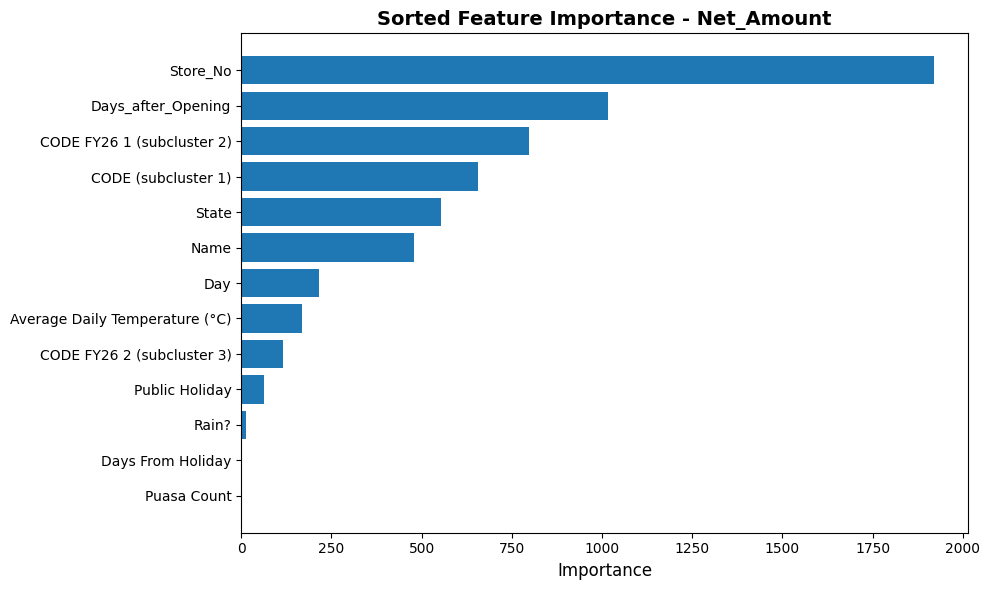

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 3) LightGBM for Net Amount (1st)
# ───────────────────────────────────────────────────────────────────────────────
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# FEATURES: set Store_No, CODE FY26 1 2 3, Name, state, day as categories


y = df['Net_Amount']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model_net = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=7)
model_net.fit(X_train, y_train)

# Predict
y_pred = model_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[Net_Amount] MAE: {mae:.2f}")
print(f"[Net_Amount] RMSE: {rmse:.2f}")
print(f"[Net_Amount] R²: {r2:.2f}")

# Param grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7],
    'subsample': [0.8, 1.0]
}

# Grid search
grid = GridSearchCV(LGBMRegressor(), param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_net = grid.best_estimator_
y_pred = best_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[Net_Amount] Best Params: {grid.best_params_}")
print(f"[Net_Amount] Tuned MAE: {mae:.2f}")
print(f"[Net_Amount] Tuned RMSE: {rmse:.2f}")
print(f"[Net_Amount] Tuned R²: {r2:.2f}")

print(f"[Net_Amount] Target Std Dev: {y.std()}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_dev = y_test.std()
ratio = rmse / std_dev
ratio_mean = mae / y.mean()
 
print(f"[Net_Amount] RMSE / SD ratio: {ratio:.2f}")
print(f"[Net_Amount] MAE / mean ratio: {ratio_mean:.2f}")

# Interpretation for RMSE
if ratio < 0.5:
    print("🟢 Excellent RMSE")
elif 0.5 <= ratio < 0.75:
    print("🟢 Good RMSE")
elif 0.75 <= ratio <= 1.0:
    print("🟡 Acceptable RMSE, but can be improved")
else:
    print("🔴 Poor RMSE – model performs worse than mean prediction")

# Interpretation for R-squared
if r2 >= 0.9:
    print("🟢 Excellent R²")
elif 0.75 <= r2 < 0.9:
    print("🟢 Good R²")
elif 0.5 <= r2 < 0.75:
    print("🟡 Acceptable R², but can be improved")
else:
    print("🔴 Weak R² – model needs improvement")

# Interpretation for MAE
if ratio_mean < 0.05:
    print("🟢 Excellent MAE")
elif 0.05 <= ratio_mean < 0.10:
    print("🟢 Good MAE")
elif 0.10 <= ratio_mean < 0.20:
    print("🟡 Acceptable MAE, but can be improved")
elif 0.20 <= ratio_mean <= 0.30:
    print("🔴 Weak MAE, high prediction error")
else:
    print("🔴 Poor MAE – likely underfitting/noisy data")

import matplotlib.pyplot as plt

import pandas as pd

# Create sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_net.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plotbest
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Sorted Feature Importance - Net_Amount', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 13
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7676.488736
[Net_Amount] MAE: 944.94
[Net_Amount] RMSE: 1416.25
[Net_Amount] R²: 0.83
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] F

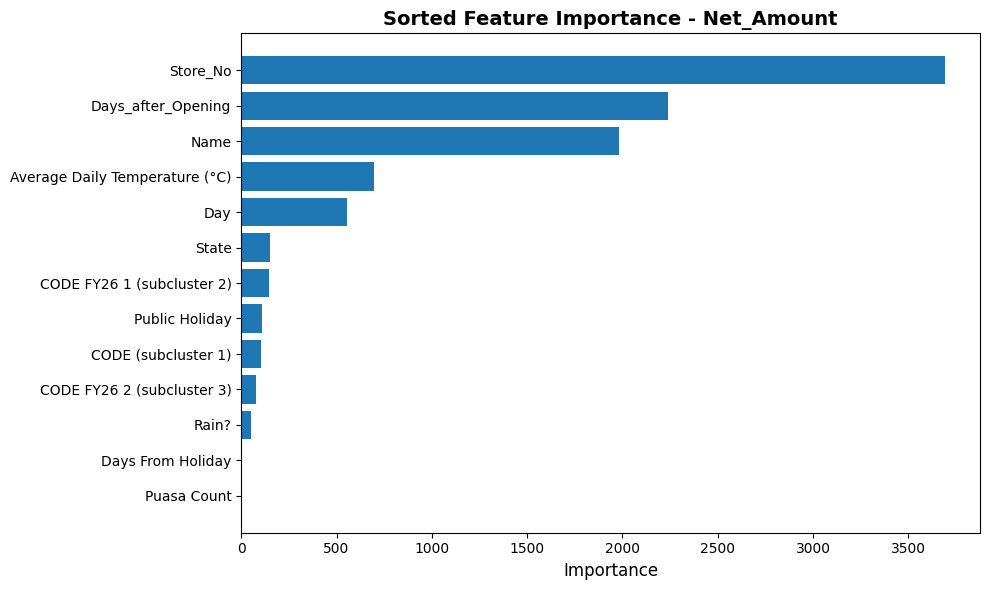

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 3) LightGBM for Net Amount (2nd)
# ───────────────────────────────────────────────────────────────────────────────
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y = df['Net_Amount']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Change some variables to category type so that categorical_features can detect and use those categories
cat_cols = [
    'Store_No', 
    'CODE (subcluster 1)', 
    'CODE FY26 1 (subcluster 2)', 
    'CODE FY26 2 (subcluster 3)', 
    'Name', 
    'State', 
    'Day'
]

for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

categorical_features = [f"{col}" for col in cat_cols]

# Model
model_net = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=7) # try to change this also
model_net.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    categorical_feature=categorical_features
)

# Predict
y_pred = model_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[Net_Amount] MAE: {mae:.2f}")
print(f"[Net_Amount] RMSE: {rmse:.2f}")
print(f"[Net_Amount] R²: {r2:.2f}")

# Param grid
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'reg_lambda': [0.0, 0.5, 1.0],
    'min_child_samples': [20, 50]
}

# Grid search
grid = GridSearchCV(LGBMRegressor(), param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_net = grid.best_estimator_
y_pred = best_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[Net_Amount] Best Params: {grid.best_params_}")
print(f"[Net_Amount] Tuned MAE: {mae:.2f}")
print(f"[Net_Amount] Tuned RMSE: {rmse:.2f}")
print(f"[Net_Amount] Tuned R²: {r2:.2f}")

print(f"[Net_Amount] Target Std Dev: {y.std()}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_dev = y_test.std()
ratio = rmse / std_dev
ratio_mean = mae / y.mean()
 
print(f"[Net_Amount] RMSE / SD ratio: {ratio:.2f}")
print(f"[Net_Amount] MAE / mean ratio: {ratio_mean:.2f}")

# Interpretation for RMSE
if ratio < 0.5:
    print("🟢 Excellent RMSE")
elif 0.5 <= ratio < 0.75:
    print("🟢 Good RMSE")
elif 0.75 <= ratio <= 1.0:
    print("🟡 Acceptable RMSE, but can be improved")
else:
    print("🔴 Poor RMSE – model performs worse than mean prediction")

# Interpretation for R-squared
if r2 >= 0.9:
    print("🟢 Excellent R²")
elif 0.75 <= r2 < 0.9:
    print("🟢 Good R²")
elif 0.5 <= r2 < 0.75:
    print("🟡 Acceptable R², but can be improved")
else:
    print("🔴 Weak R² – model needs improvement")

# Interpretation for MAE
if ratio_mean < 0.05:
    print("🟢 Excellent MAE")
elif 0.05 <= ratio_mean < 0.10:
    print("🟢 Good MAE")
elif 0.10 <= ratio_mean < 0.20:
    print("🟡 Acceptable MAE, but can be improved")
elif 0.20 <= ratio_mean <= 0.30:
    print("🔴 Weak MAE, high prediction error")
else:
    print("🔴 Poor MAE – likely underfitting/noisy data")

import matplotlib.pyplot as plt

import pandas as pd

# Create sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_net.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Sorted Feature Importance - Net_Amount', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 12
[LightGBM] [Info] Start training from score 7676.488736
[Net_Amount] MAE: 1521.77
[Net_Amount] RMSE: 2097.21
[Net_Amount] R²: 0.63


c:\Users\chiaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
c:\Users\chiaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Name,State,Day,CODE_subcluster_1_,CODE_FY26_1_subcluster_2_,CODE_FY26_2_subcluster_3_, categorical_column=0,1,2,6,7,8 will be ignored. Current value: categorical_feature=Name,State,Day,CODE_subcluster_1_,CODE_FY26_1_subcluster_2_,CODE_FY26_2_subcluster_3_
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 12
[LightGBM] [Info] Start training from score 7676.488736
[Net_Amount] Best Params: {'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 50, 'reg_lambda': 0.0}
[Net_Amount] Tuned MAE: 1350.78
[Net_Amount] Tuned RMSE: 1867.02
[Net_Amount] Tuned R²: 0.71
[Net_Amount] Target Std Dev: 3473.06440034760

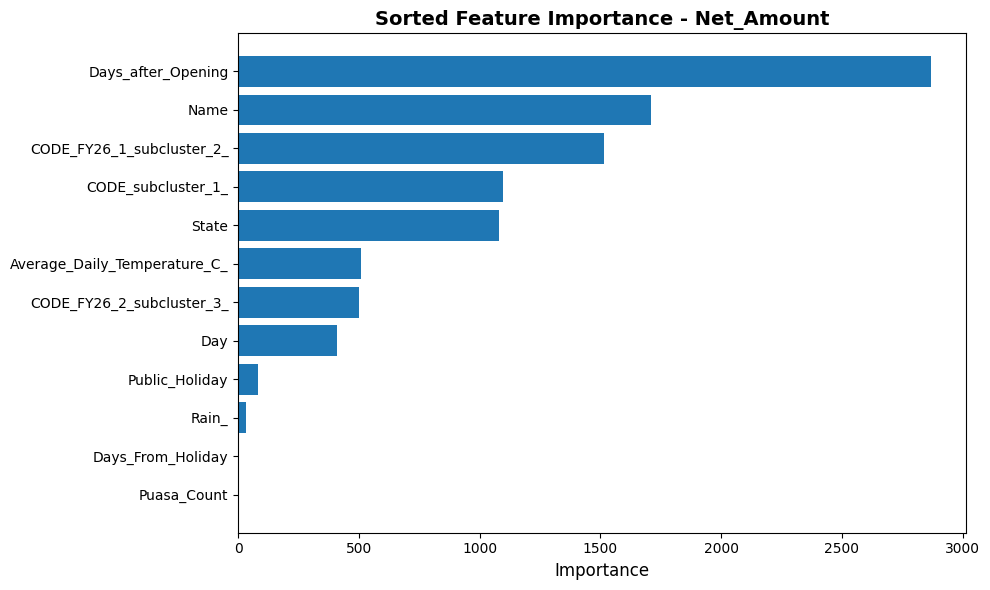

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 3) LightGBM for Net Amount drop Store_No (3rd)
# ───────────────────────────────────────────────────────────────────────────────
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
df.columns = df.columns.str.replace(r'[^\w]+', '_', regex=True)
X = df.drop(['Net_Amount', 'TC','Store_No'], axis=1)
y = df['Net_Amount']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_cols = ['CODE_subcluster_1', 'CODE_FY26_1_subcluster_2_', 'CODE_FY26_2_subcluster_3_']

# Change some variables to category type so that categorical_features can detect and use those categories
cat_cols = [col for col in X.columns if col in ['Name', 'State', 'Day', 'CODE_subcluster_1_', 
                                                'CODE_FY26_1_subcluster_2_','CODE_FY26_2_subcluster_3_']]

for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    X_test[col] = X_test[col].cat.set_categories(X_train[col].cat.categories)

categorical_features = [f"{col}" for col in cat_cols]

# Model
model_net = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=7) # try to change this also
model_net.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    categorical_feature=categorical_features
)

# Predict
y_pred = model_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[Net_Amount] MAE: {mae:.2f}")
print(f"[Net_Amount] RMSE: {rmse:.2f}")
print(f"[Net_Amount] R²: {r2:.2f}")

# Param grid
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'reg_lambda': [0.0, 0.5, 1.0],
    'min_child_samples': [20, 50]
}

# Grid search
base_model = LGBMRegressor()
base_model.set_params(categorical_feature=cat_cols)
grid = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_net = grid.best_estimator_
y_pred = best_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[Net_Amount] Best Params: {grid.best_params_}")
print(f"[Net_Amount] Tuned MAE: {mae:.2f}")
print(f"[Net_Amount] Tuned RMSE: {rmse:.2f}")
print(f"[Net_Amount] Tuned R²: {r2:.2f}")

print(f"[Net_Amount] Target Std Dev: {y.std()}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_dev = y_test.std()
ratio = rmse / std_dev
ratio_mean = mae / y.mean()
 
print(f"[Net_Amount] RMSE / SD ratio: {ratio:.2f}")
print(f"[Net_Amount] MAE / mean ratio: {ratio_mean:.2f}")

# Interpretation for RMSE
if ratio < 0.5:
    print("🟢 Excellent RMSE")
elif 0.5 <= ratio < 0.75:
    print("🟢 Good RMSE")
elif 0.75 <= ratio <= 1.0:
    print("🟡 Acceptable RMSE, but can be improved")
else:
    print("🔴 Poor RMSE – model performs worse than mean prediction")

# Interpretation for R-squared
if r2 >= 0.9:
    print("🟢 Excellent R²")
elif 0.75 <= r2 < 0.9:
    print("🟢 Good R²")
elif 0.5 <= r2 < 0.75:
    print("🟡 Acceptable R², but can be improved")
else:
    print("🔴 Weak R² – model needs improvement")

# Interpretation for MAE
if ratio_mean < 0.05:
    print("🟢 Excellent MAE")
elif 0.05 <= ratio_mean < 0.10:
    print("🟢 Good MAE")
elif 0.10 <= ratio_mean < 0.20:
    print("🟡 Acceptable MAE, but can be improved")
elif 0.20 <= ratio_mean <= 0.30:
    print("🔴 Weak MAE, high prediction error")
else:
    print("🔴 Poor MAE – likely underfitting/noisy data")

import matplotlib.pyplot as plt

import pandas as pd

# Create sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_net.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Sorted Feature Importance - Net_Amount', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 9
[LightGBM] [Info] Start training from score 7676.488736
[Net_Amount] MAE: 1518.18
[Net_Amount] RMSE: 2093.50
[Net_Amount] R²: 0.63


c:\Users\chiaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
c:\Users\chiaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Name,State,Day,CODE_subcluster_1_,CODE_FY26_1_subcluster_2_,CODE_FY26_2_subcluster_3_, categorical_column=0,1,2,4,5,6 will be ignored. Current value: categorical_feature=Name,State,Day,CODE_subcluster_1_,CODE_FY26_1_subcluster_2_,CODE_FY26_2_subcluster_3_
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 9
[LightGBM] [Info] Start training from score 7676.488736
[Net_Amount] Best Params: {'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 50, 'n_estimators': 200, 'num_leaves': 50, 'reg_lambda': 0.0}
[Net_Amount] Tuned MAE: 1347.61
[Net_Amount] Tuned RMSE: 1864.13
[Net_Amount] Tuned R²: 0.71
[Net_Amount] Target Std Dev: 3473.064400347609

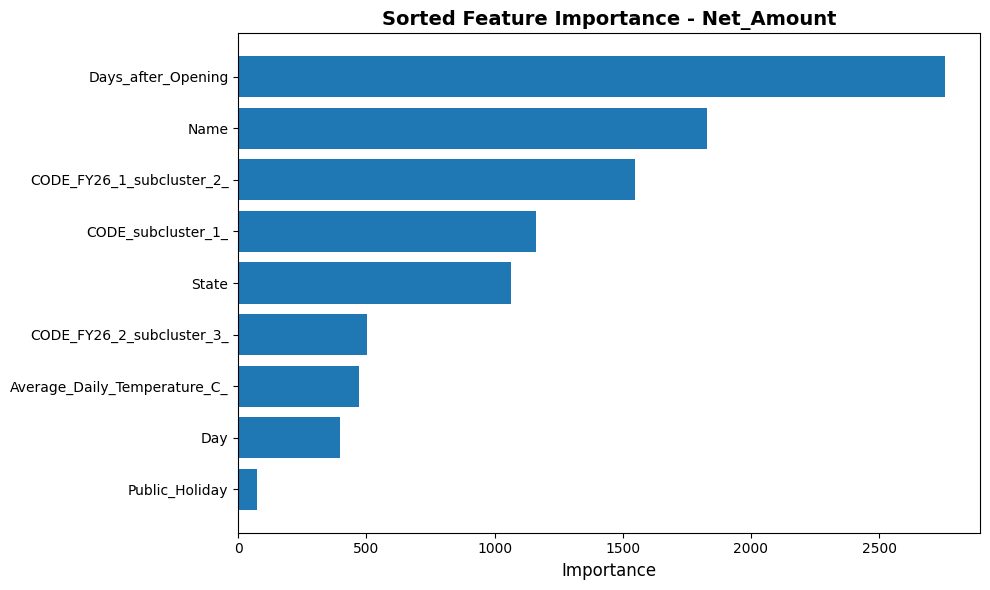

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 3) LightGBM for Net Amount drop Store_No, Rain?, Days From Holiday, Puasa Count (4th)
# ───────────────────────────────────────────────────────────────────────────────
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
df.columns = df.columns.str.replace(r'[^\w]+', '_', regex=True)
X = df.drop(['Net_Amount', 'TC','Store_No','Rain_', 'Days_From_Holiday','Puasa_Count'], axis=1)
y = df['Net_Amount']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_cols = ['CODE_subcluster_1', 'CODE_FY26_1_subcluster_2_', ...]

# Change some variables to category type so that categorical_features can detect and use those categories
cat_cols = [col for col in X.columns if col in ['Name', 'State', 'Day', 'CODE_subcluster_1_', 
                                                'CODE_FY26_1_subcluster_2_','CODE_FY26_2_subcluster_3_']]

for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    X_test[col] = X_test[col].cat.set_categories(X_train[col].cat.categories)

categorical_features = [f"{col}" for col in cat_cols]

# Model
model_net = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=7) # try to change this also
model_net.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    categorical_feature=categorical_features
)

# Predict
y_pred = model_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[Net_Amount] MAE: {mae:.2f}")
print(f"[Net_Amount] RMSE: {rmse:.2f}")
print(f"[Net_Amount] R²: {r2:.2f}")

# Param grid
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'reg_lambda': [0.0, 0.5, 1.0],
    'min_child_samples': [20, 50]
}

# Grid search
base_model = LGBMRegressor()
base_model.set_params(categorical_feature=cat_cols)
grid = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_net = grid.best_estimator_
y_pred = best_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[Net_Amount] Best Params: {grid.best_params_}")
print(f"[Net_Amount] Tuned MAE: {mae:.2f}")
print(f"[Net_Amount] Tuned RMSE: {rmse:.2f}")
print(f"[Net_Amount] Tuned R²: {r2:.2f}")

print(f"[Net_Amount] Target Std Dev: {y.std()}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_dev = y_test.std()
ratio = rmse / std_dev
ratio_mean = mae / y.mean()
 
print(f"[Net_Amount] RMSE / SD ratio: {ratio:.2f}")
print(f"[Net_Amount] MAE / mean ratio: {ratio_mean:.2f}")

# Interpretation for RMSE
if ratio < 0.5:
    print("🟢 Excellent RMSE")
elif 0.5 <= ratio < 0.75:
    print("🟢 Good RMSE")
elif 0.75 <= ratio <= 1.0:
    print("🟡 Acceptable RMSE, but can be improved")
else:
    print("🔴 Poor RMSE – model performs worse than mean prediction")

# Interpretation for R-squared
if r2 >= 0.9:
    print("🟢 Excellent R²")
elif 0.75 <= r2 < 0.9:
    print("🟢 Good R²")
elif 0.5 <= r2 < 0.75:
    print("🟡 Acceptable R², but can be improved")
else:
    print("🔴 Weak R² – model needs improvement")

# Interpretation for MAE
if ratio_mean < 0.05:
    print("🟢 Excellent MAE")
elif 0.05 <= ratio_mean < 0.10:
    print("🟢 Good MAE")
elif 0.10 <= ratio_mean < 0.20:
    print("🟡 Acceptable MAE, but can be improved")
elif 0.20 <= ratio_mean <= 0.30:
    print("🔴 Weak MAE, high prediction error")
else:
    print("🔴 Poor MAE – likely underfitting/noisy data")

import matplotlib.pyplot as plt

import pandas as pd

# Create sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_net.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Sorted Feature Importance - Net_Amount', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 13
[LightGBM] [Info] Start training from score 495.132805
[TC] MAE: 82.01
[TC] RMSE: 116.83
[TC] R²: 0.75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 13
[LightGBM] [Info] Start trainin

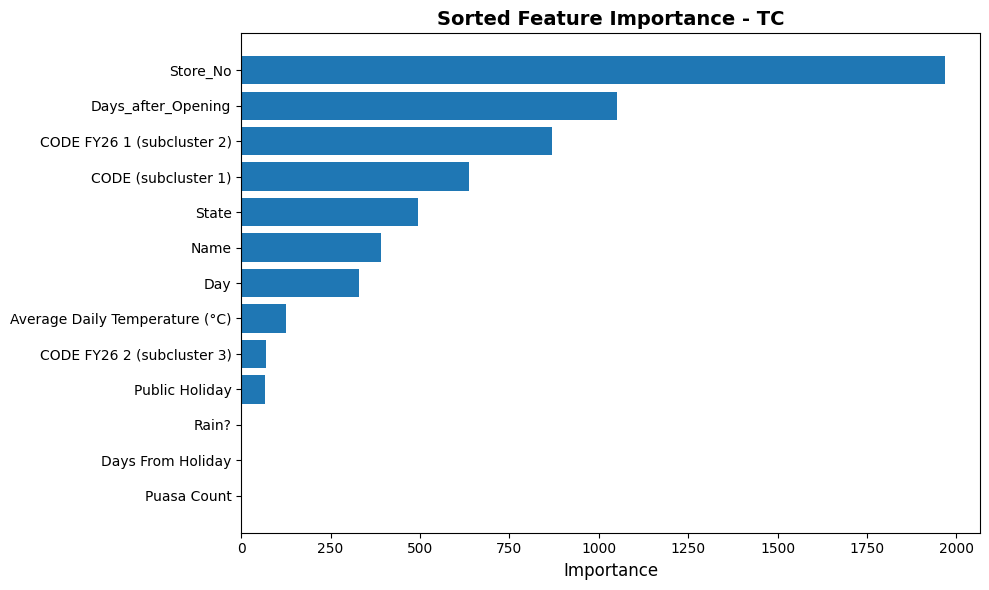

In [8]:
# Little note: need to rerun 1) since I removed Store No for draft 3

# ───────────────────────────────────────────────────────────────────────────────
# 4) LightGBM for TC (1st)
# ───────────────────────────────────────────────────────────────────────────────
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y = df['TC']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model_net = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=7)
model_net.fit(X_train, y_train)

# Predict
y_pred = model_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[TC] MAE: {mae:.2f}")
print(f"[TC] RMSE: {rmse:.2f}")
print(f"[TC] R²: {r2:.2f}")

# Param grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7],
    'subsample': [0.8, 1.0]
}

# Grid search
grid = GridSearchCV(LGBMRegressor(), param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_tc = grid.best_estimator_
y_pred = best_tc.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[TC] Best Params: {grid.best_params_}")
print(f"[TC] Tuned MAE: {mae:.2f}")
print(f"[TC] Tuned RMSE: {rmse:.2f}")
print(f"[TC] Tuned R²: {r2:.2f}")

print(f"[TC] Target Std Dev: {y.std()}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_dev = y_test.std()
ratio = rmse / std_dev
ratio_mean = mae / y.mean()
 
print(f"[TC] RMSE / SD ratio: {ratio:.2f}")
print(f"[TC] MAE / mean ratio: {ratio_mean:.2f}")

# Interpretation for RMSE
if ratio < 0.5:
    print("🟢 Excellent RMSE")
elif 0.5 <= ratio < 0.75:
    print("🟢 Good RMSE")
elif 0.75 <= ratio <= 1.0:
    print("🟡 Acceptable RMSE, but can be improved")
else:
    print("🔴 Poor RMSE – model performs worse than mean prediction")

# Interpretation for R-squared
if r2 >= 0.9:
    print("🟢 Excellent R²")
elif 0.75 <= r2 < 0.9:
    print("🟢 Good R²")
elif 0.5 <= r2 < 0.75:
    print("🟡 Acceptable R², but can be improved")
else:
    print("🔴 Weak R² – model needs improvement")

# Interpretation for MAE
if ratio_mean < 0.05:
    print("🟢 Excellent MAE")
elif 0.05 <= ratio_mean < 0.10:
    print("🟢 Good MAE")
elif 0.10 <= ratio_mean < 0.20:
    print("🟡 Acceptable MAE, but can be improved")
elif 0.20 <= ratio_mean <= 0.30:
    print("🔴 Weak MAE, high prediction error")
else:
    print("🔴 Poor MAE – likely underfitting/noisy data")

import matplotlib.pyplot as plt

# Feature importance
import pandas as pd

# Create sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_tc.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Sorted Feature Importance - TC', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 13
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 495.132805
[Net_Amount] MAE: 54.11
[Net_Amount] RMSE: 84.01
[Net_Amount] R²: 0.87
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For c

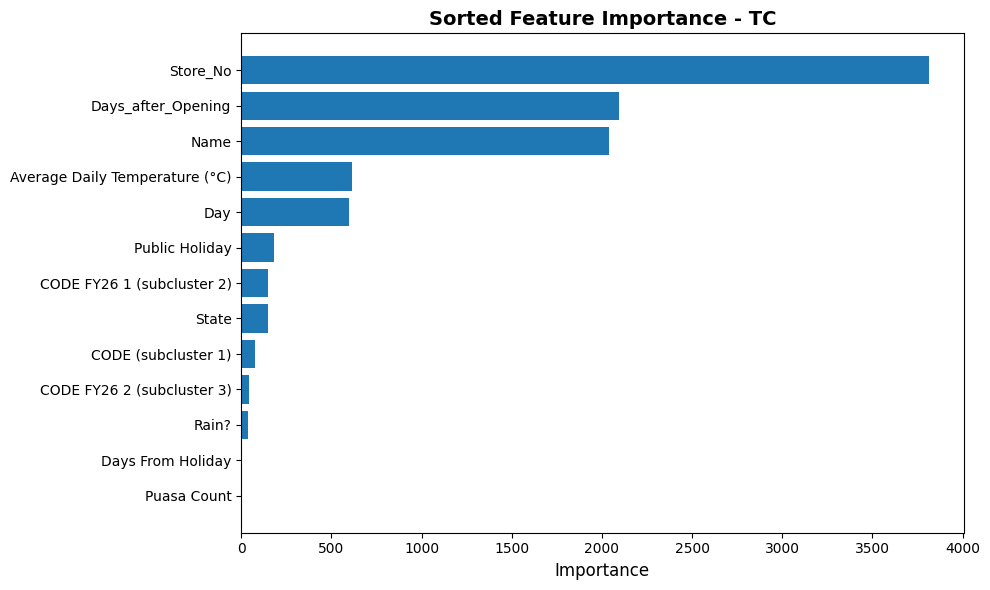

In [9]:
# ───────────────────────────────────────────────────────────────────────────────
# 12) LightGBM for TC (2nd)
# ───────────────────────────────────────────────────────────────────────────────
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y = df['TC']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Change some variables to category type so that categorical_features can detect and use those categories
cat_cols = [
    'Store_No', 
    'CODE (subcluster 1)', 
    'CODE FY26 1 (subcluster 2)', 
    'CODE FY26 2 (subcluster 3)', 
    'Name', 
    'State', 
    'Day'
]

for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

categorical_features = [f"{col}" for col in cat_cols]

# Model
model_net = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=7) # try to change this also
model_net.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    categorical_feature=categorical_features
)

# Predict
y_pred = model_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[Net_Amount] MAE: {mae:.2f}")
print(f"[Net_Amount] RMSE: {rmse:.2f}")
print(f"[Net_Amount] R²: {r2:.2f}")

# Param grid
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'reg_lambda': [0.0, 0.5, 1.0],
    'min_child_samples': [20, 50]
}

# Grid search
grid = GridSearchCV(LGBMRegressor(), param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_tc = grid.best_estimator_
y_pred = best_tc.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[TC] Best Params: {grid.best_params_}")
print(f"[TC] Tuned MAE: {mae:.2f}")
print(f"[TC] Tuned RMSE: {rmse:.2f}")
print(f"[TC] Tuned R²: {r2:.2f}")

print(f"[TC] Target Std Dev: {y.std()}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_dev = y_test.std()
ratio = rmse / std_dev
ratio_mean = mae / y.mean()
 
print(f"[TC] RMSE / SD ratio: {ratio:.2f}")
print(f"[TC] MAE / mean ratio: {ratio_mean:.2f}")

# Interpretation for RMSE
if ratio < 0.5:
    print("🟢 Excellent RMSE")
elif 0.5 <= ratio < 0.75:
    print("🟢 Good RMSE")
elif 0.75 <= ratio <= 1.0:
    print("🟡 Acceptable RMSE, but can be improved")
else:
    print("🔴 Poor RMSE – model performs worse than mean prediction")

# Interpretation for R-squared
if r2 >= 0.9:
    print("🟢 Excellent R²")
elif 0.75 <= r2 < 0.9:
    print("🟢 Good R²")
elif 0.5 <= r2 < 0.75:
    print("🟡 Acceptable R², but can be improved")
else:
    print("🔴 Weak R² – model needs improvement")

# Interpretation for MAE
if ratio_mean < 0.05:
    print("🟢 Excellent MAE")
elif 0.05 <= ratio_mean < 0.10:
    print("🟢 Good MAE")
elif 0.10 <= ratio_mean < 0.20:
    print("🟡 Acceptable MAE, but can be improved")
elif 0.20 <= ratio_mean <= 0.30:
    print("🔴 Weak MAE, high prediction error")
else:
    print("🔴 Poor MAE – likely underfitting/noisy data")

import matplotlib.pyplot as plt

import pandas as pd

# Create sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_tc.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Sorted Feature Importance - TC', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 12
[LightGBM] [Info] Start training from score 495.132805
[TC] MAE: 91.26
[TC] RMSE: 129.65
[TC] R²: 0.69


c:\Users\chiaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
c:\Users\chiaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Name,State,Day,CODE_subcluster_1_,CODE_FY26_1_subcluster_2_,CODE_FY26_2_subcluster_3_, categorical_column=0,1,2,6,7,8 will be ignored. Current value: categorical_feature=Name,State,Day,CODE_subcluster_1_,CODE_FY26_1_subcluster_2_,CODE_FY26_2_subcluster_3_
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 12
[LightGBM] [Info] Start training from score 495.132805
[TC] Best Params: {'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 50, 'reg_lambda': 1.0}
[TC] Tuned MAE: 79.68
[TC] Tuned RMSE: 113.76
[TC] Tuned R²: 0.76
[TC] Target Std Dev: 234.53646431693107
[TC] RMSE / SD ratio: 0.49
[TC] MAE / mea

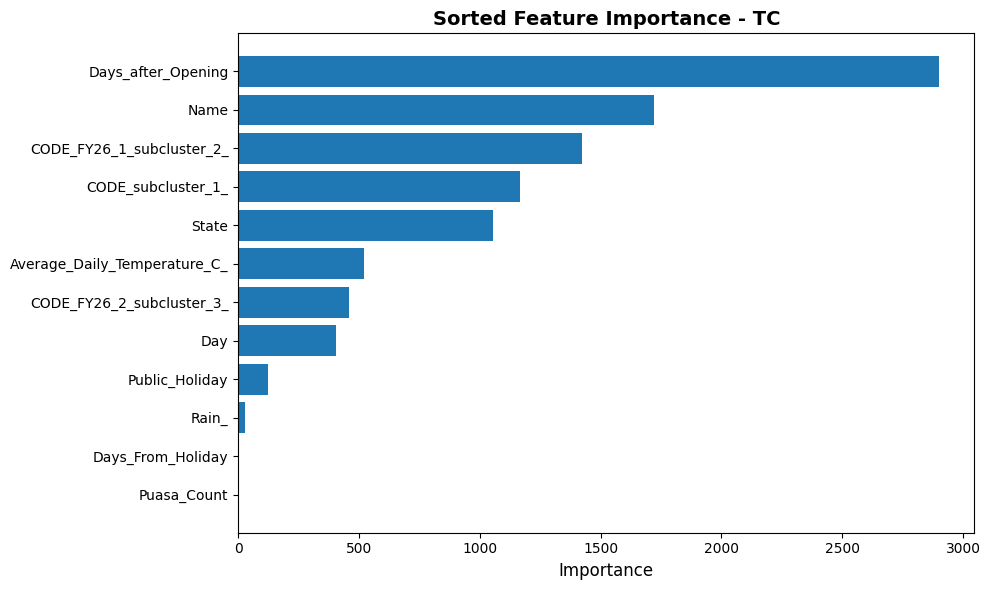

In [10]:
# ───────────────────────────────────────────────────────────────────────────────
# 12) LightGBM for TC drop Store_No (3rd)
# ───────────────────────────────────────────────────────────────────────────────
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
df.columns = df.columns.str.replace(r'[^\w]+', '_', regex=True)
X = df.drop(['Net_Amount', 'TC','Store_No'], axis=1)
y = df['TC']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_cols = ['CODE_subcluster_1', 'CODE_FY26_1_subcluster_2_', 'CODE_FY26_2_subcluster_3_']

# Change some variables to category type so that categorical_features can detect and use those categories
cat_cols = [col for col in X.columns if col in ['Name', 'State', 'Day', 'CODE_subcluster_1_', 
                                                'CODE_FY26_1_subcluster_2_','CODE_FY26_2_subcluster_3_']]

for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    X_test[col] = X_test[col].cat.set_categories(X_train[col].cat.categories)

categorical_features = [f"{col}" for col in cat_cols]

# Model
model_net = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=7) # try to change this also
model_net.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    categorical_feature=categorical_features
)

# Predict
y_pred = model_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[TC] MAE: {mae:.2f}")
print(f"[TC] RMSE: {rmse:.2f}")
print(f"[TC] R²: {r2:.2f}")

# Param grid
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'reg_lambda': [0.0, 0.5, 1.0],
    'min_child_samples': [20, 50]
}

# Grid search
base_model = LGBMRegressor()
base_model.set_params(categorical_feature=cat_cols)
grid = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_tc = grid.best_estimator_
y_pred = best_tc.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[TC] Best Params: {grid.best_params_}")
print(f"[TC] Tuned MAE: {mae:.2f}")
print(f"[TC] Tuned RMSE: {rmse:.2f}")
print(f"[TC] Tuned R²: {r2:.2f}")

print(f"[TC] Target Std Dev: {y.std()}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_dev = y_test.std()
ratio = rmse / std_dev
ratio_mean = mae / y.mean()
 
print(f"[TC] RMSE / SD ratio: {ratio:.2f}")
print(f"[TC] MAE / mean ratio: {ratio_mean:.2f}")

# Interpretation for RMSE
if ratio < 0.5:
    print("🟢 Excellent RMSE")
elif 0.5 <= ratio < 0.75:
    print("🟢 Good RMSE")
elif 0.75 <= ratio <= 1.0:
    print("🟡 Acceptable RMSE, but can be improved")
else:
    print("🔴 Poor RMSE – model performs worse than mean prediction")

# Interpretation for R-squared
if r2 >= 0.9:
    print("🟢 Excellent R²")
elif 0.75 <= r2 < 0.9:
    print("🟢 Good R²")
elif 0.5 <= r2 < 0.75:
    print("🟡 Acceptable R², but can be improved")
else:
    print("🔴 Weak R² – model needs improvement")

# Interpretation for MAE
if ratio_mean < 0.05:
    print("🟢 Excellent MAE")
elif 0.05 <= ratio_mean < 0.10:
    print("🟢 Good MAE")
elif 0.10 <= ratio_mean < 0.20:
    print("🟡 Acceptable MAE, but can be improved")
elif 0.20 <= ratio_mean <= 0.30:
    print("🔴 Weak MAE, high prediction error")
else:
    print("🔴 Poor MAE – likely underfitting/noisy data")

import matplotlib.pyplot as plt

import pandas as pd

# Create sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_tc.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Sorted Feature Importance - TC', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 9
[LightGBM] [Info] Start training from score 495.132805
[TC] MAE: 91.27
[TC] RMSE: 129.93
[TC] R²: 0.69


c:\Users\chiaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
c:\Users\chiaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Name,State,Day,CODE_subcluster_1_,CODE_FY26_1_subcluster_2_,CODE_FY26_2_subcluster_3_, categorical_column=0,1,2,4,5,6 will be ignored. Current value: categorical_feature=Name,State,Day,CODE_subcluster_1_,CODE_FY26_1_subcluster_2_,CODE_FY26_2_subcluster_3_
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 711063, number of used features: 9
[LightGBM] [Info] Start training from score 495.132805
[TC] Best Params: {'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 50, 'reg_lambda': 0.0}
[TC] Tuned MAE: 80.52
[TC] Tuned RMSE: 114.65
[TC] Tuned R²: 0.76
[TC] Target Std Dev: 234.53646431693107
[TC] RMSE / SD ratio: 0.49
[TC] MAE / mean

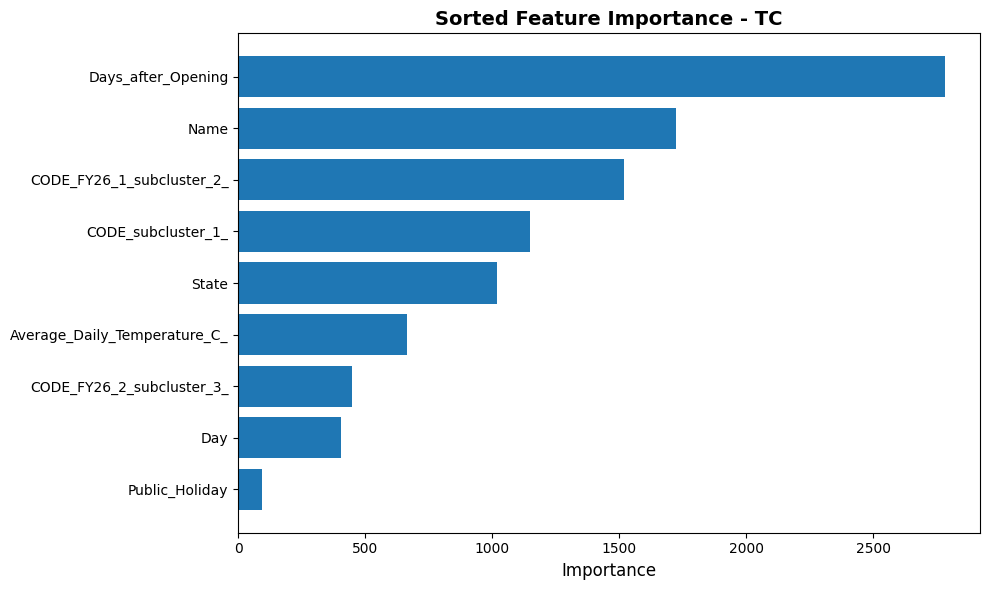

In [11]:
# ───────────────────────────────────────────────────────────────────────────────
# 12) LightGBM for TC drop Store_No, Rain?, Days From Holiday, Puasa Count (4th)
# ───────────────────────────────────────────────────────────────────────────────
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
df.columns = df.columns.str.replace(r'[^\w]+', '_', regex=True)
X = df.drop(['Net_Amount', 'TC','Store_No','Rain_', 'Days_From_Holiday','Puasa_Count'], axis=1)
y = df['TC']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_cols = ['CODE_subcluster_1', 'CODE_FY26_1_subcluster_2_', ...]

# Change some variables to category type so that categorical_features can detect and use those categories
cat_cols = [col for col in X.columns if col in ['Name', 'State', 'Day', 'CODE_subcluster_1_', 
                                                'CODE_FY26_1_subcluster_2_','CODE_FY26_2_subcluster_3_']]

for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    X_test[col] = X_test[col].cat.set_categories(X_train[col].cat.categories)

categorical_features = [f"{col}" for col in cat_cols]

# Model
model_net = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=7) # try to change this also
model_net.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    categorical_feature=categorical_features
)

# Predict
y_pred = model_net.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[TC] MAE: {mae:.2f}")
print(f"[TC] RMSE: {rmse:.2f}")
print(f"[TC] R²: {r2:.2f}")

# Param grid
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'reg_lambda': [0.0, 0.5, 1.0],
    'min_child_samples': [20, 50]
}

# Grid search
base_model = LGBMRegressor()
base_model.set_params(categorical_feature=cat_cols)
grid = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_tc = grid.best_estimator_
y_pred = best_tc.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[TC] Best Params: {grid.best_params_}")
print(f"[TC] Tuned MAE: {mae:.2f}")
print(f"[TC] Tuned RMSE: {rmse:.2f}")
print(f"[TC] Tuned R²: {r2:.2f}")

print(f"[TC] Target Std Dev: {y.std()}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_dev = y_test.std()
ratio = rmse / std_dev
ratio_mean = mae / y.mean()
 
print(f"[TC] RMSE / SD ratio: {ratio:.2f}")
print(f"[TC] MAE / mean ratio: {ratio_mean:.2f}")

# Interpretation for RMSE
if ratio < 0.5:
    print("🟢 Excellent RMSE")
elif 0.5 <= ratio < 0.75:
    print("🟢 Good RMSE")
elif 0.75 <= ratio <= 1.0:
    print("🟡 Acceptable RMSE, but can be improved")
else:
    print("🔴 Poor RMSE – model performs worse than mean prediction")

# Interpretation for R-squared
if r2 >= 0.9:
    print("🟢 Excellent R²")
elif 0.75 <= r2 < 0.9:
    print("🟢 Good R²")
elif 0.5 <= r2 < 0.75:
    print("🟡 Acceptable R², but can be improved")
else:
    print("🔴 Weak R² – model needs improvement")

# Interpretation for MAE
if ratio_mean < 0.05:
    print("🟢 Excellent MAE")
elif 0.05 <= ratio_mean < 0.10:
    print("🟢 Good MAE")
elif 0.10 <= ratio_mean < 0.20:
    print("🟡 Acceptable MAE, but can be improved")
elif 0.20 <= ratio_mean <= 0.30:
    print("🔴 Weak MAE, high prediction error")
else:
    print("🔴 Poor MAE – likely underfitting/noisy data")

import matplotlib.pyplot as plt

import pandas as pd

# Create sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_tc.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Sorted Feature Importance - TC', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

Epoch 1/50
22221/22221 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 10756108.0000 - mae: 1748.5752 - val_loss: 1695732.2500 - val_mae: 655.3431 - learning_rate: 5.0000e-04
Epoch 2/50
22221/22221 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 2794866.2500 - mae: 889.0093 - val_loss: 1516031.3750 - val_mae: 612.0569 - learning_rate: 5.0000e-04
Epoch 3/50
22221/22221 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - loss: 2549231.5000 - mae: 846.8876 - val_loss: 1578356.7500 - val_mae: 602.7739 - learning_rate: 5.0000e-04
Epoch 4/50
22221/22221 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - loss: 2384682.2500 - mae: 820.3348 - val_loss: 1586952.1250 - val_mae: 595.4532 - learning_rate: 5.0000e-04
Epoch 5/50
22200/22221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2324059.5000 - mae: 804.5329
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
22221/22221 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 2324031.7500 - mae: 804.5280 - val_loss: 2288728.0000 - val_mae: 612.4010 - learning_rate: 5.0000e-04
Epoch

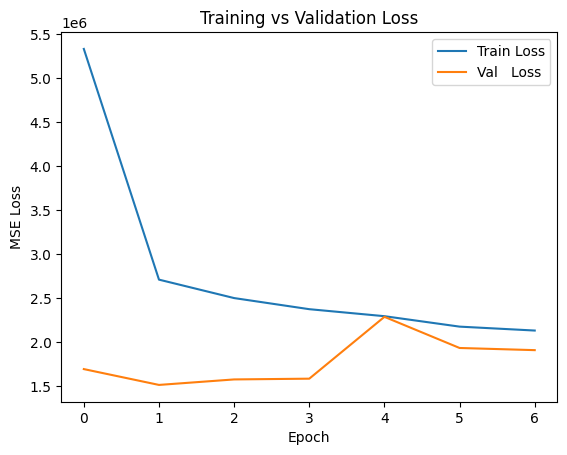

In [2]:
    # ───────────────────────────────────────────────────────────────────────────────
    # 13) Neural Networks (Feed Forward)
    # ───────────────────────────────────────────────────────────────────────────────
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
    from tensorflow.keras.models import Model
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import re
    import numpy as np 
    import matplotlib.pyplot as plt

    ### Data preprocessing
    y = df[['Net_Amount','TC']].values#

    # Label-encode categoricals in place
    cat_cols = [
        'Store_No','Name','State','Day',
        'CODE (subcluster 1)','CODE FY26 1 (subcluster 2)',
        'CODE FY26 2 (subcluster 3)','Rain?','Public Holiday'
    ]
    df[cat_cols] = df[cat_cols].fillna("Missing")
    for col in cat_cols:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    # Define numeric cols (still in df)
    numeric_cols = ['Days From Holiday','Puasa Count',
        'Days_after_Opening','Average Daily Temperature (°C)'
    ]

    # Split the *full* DataFrame so you keep both cat & num
    train_df, test_df, y_train, y_test = train_test_split(
        df, y, test_size=0.2, random_state=42
    )

    # Fit scaler on training numerics, transform both
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(train_df[numeric_cols])
    X_test_num  = scaler.transform(test_df[numeric_cols])

    # Extract each categorical column as an array
    X_train_cat = [train_df[col].values for col in cat_cols]
    X_test_cat  = [test_df[col].values  for col in cat_cols]

    # Combine into the list your model expects:
    X_train_input = X_train_cat + [X_train_num]
    X_test_input  = X_test_cat  + [X_test_num]

    ### Building the Embedding + Dense Model
    # ========== Define Inputs ==========
    n_uniques = {col: df[col].nunique() for col in cat_cols}

    def clean(col):
        # replace any character that is not A–Z, a–z, 0–9 or underscore with underscore
        return re.sub(r'[^A-Za-z0-9_]+', '_', col)             # to change Rain?embed into Rain_embed

    cat_inputs = []
    cat_embeds = []

    for col in cat_cols:
        safe = clean(col)
        inp = Input(shape=(1,), name=f"{safe}_in")
        
        vocab_size = n_uniques[col]
        embed_dim = int(np.log2(vocab_size)) + 1  # adaptive size

        emb = Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            name=f"{safe}_emb"
        )(inp)

        flat = Flatten(name=f"{safe}_flat")(emb)
        cat_inputs.append(inp)
        cat_embeds.append(flat)

    # Numeric Input
    numeric_input = Input(
        shape=(X_train_num.shape[1],), 
        name='numeric_in'
    )

    # Combine all Keras Inputs
    all_inputs = cat_inputs + [numeric_input]

    # ========== Concatenate Embeddings + Numeric Inputs ==========
    x = Concatenate()(cat_embeds + [numeric_input])

    # ========== Updated Network Architecture ==========
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(32, activation='relu')(x)
    output = Dense(2)(x)  # Predict Net_Amount and TC

    # ========== Build Model ==========
    model = Model(inputs=all_inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate= 0.0005),  # Reduced from default 1e-3 if needed
        loss='mse',
        metrics=['mae'])

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,       # reduce by half
        patience=3,       # wait 3 epochs of no improvement
        min_lr=1e-6,      # don't go below this
        verbose=1
    )

    # ========== Add EarlyStopping ==========
    early_stop = EarlyStopping(
        monitor='val_loss',         # Watch validation loss
        patience=5,                # Stop after 5 bad epochs (no improvement)
        min_delta=0.0001,
        mode='min',                 
        restore_best_weights=True  # Roll back to the best weights seen
    )

    # Train and capture history for plotting
    history = model.fit(
        x=X_train_input,
        y=y_train,
        validation_data=(X_test_input, y_test),
        epochs=50,          
        batch_size=32,
        callbacks=[early_stop, lr_scheduler],
        verbose=1
    )

    ### Evaluation
    # 1) Raw evaluation
    loss, mae = model.evaluate(X_test_input, y_test, verbose=0)
    print(f"\nTest MSE: {loss:.2f}, Test MAE: {mae:.2f}")

    # 2) Predictions
    predictions = model.predict(X_test_input)
    true_net, true_tc = y_test[:, 0], y_test[:, 1]
    pred_net, pred_tc = predictions[:, 0], predictions[:, 1]

    # 3) Metric helper
    def summarize(y_true, y_pred, name):
        mse  = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        std  = np.std(y_true)
        mean = np.mean(y_true)
        print(f"\n— {name} —")
        print(f"RMSE : {rmse:.2f} (vs STD {std:.2f})")
        print(f"MAE  : {mae:.2f} (vs Mean{mean:.2f})")
        print(f"R²   : {r2:.3f}")

    summarize(true_net, pred_net, "Net_Amount")
    summarize(true_tc,  pred_tc,  "TC")


    ### 4) Loss Curve Plot ###
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val   Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()




Changes:
1. Putting Net_Amount and TC on the same scale so that MSE loss won't be dominated by larger-magnitude target (Net_Amount)
2. Setting two task-specific heads - after a shared trunk the network branches, letting each target learn features that matter only to it, reducing negative interference
3. L2 weight regularisation - penalising large weights, discouraging complex co-adaptations and reducing over-fitting
4. Lower dropout (0.30) + tighter patience (3) - a good amount of regularisation but allows the model to converge faster + earlier early-stop
5. Quicker ReduceLROnPlateau - halves the learning rate after just 2 stagnant epochs, helping the optimiser settle into a better minimum once progress plateaus
6. Interpretation - for easy interpretation of values

Epoch 1/50
22221/22221 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - loss: 0.9769 - net_loss: 0.5011 - net_mae: 0.4718 - tc_loss: 0.4521 - tc_mae: 0.4370 - val_loss: 0.4298 - val_net_loss: 0.2218 - val_net_mae: 0.3064 - val_tc_loss: 0.1852 - val_tc_mae: 0.2682 - learning_rate: 5.0000e-04
Epoch 2/50
22221/22221 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.4985 - net_loss: 0.2607 - net_mae: 0.3365 - tc_loss: 0.2156 - tc_mae: 0.2981 - val_loss: 0.4335 - val_net_loss: 0.2154 - val_net_mae: 0.2972 - val_tc_loss: 0.1968 - val_tc_mae: 0.2620 - learning_rate: 5.0000e-04
Epoch 3/50
22221/22221 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 0.4604 - net_loss: 0.2411 - net_mae: 0.3231 - tc_loss: 0.1983 - tc_mae: 0.2836 - val_loss: 0.4288 - val_net_loss: 0.2231 - val_net_mae: 0.2922 - val_tc_loss: 0.1851 - val_tc_mae: 0.2551 - learning_rate: 5.0000e-04
Epoch 4/50
22221/22221 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 0.4393 - net_loss: 0.2296 - net_mae: 0.3157 - tc_loss: 0.1892 - tc_mae: 0.2774 - val_loss: 0.4167 

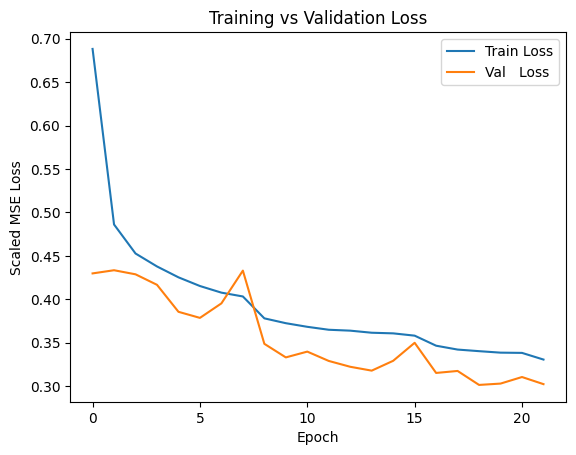

In [5]:
# ───────────────────────────────────────────────────────────────────────────────
# 13) Neural Networks (Feed-Forward) – Improved version with interpretation
# ───────────────────────────────────────────────────────────────────────────────
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Input, Embedding, Flatten, Concatenate,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import re, numpy as np, matplotlib.pyplot as plt

# ── 1) Data preprocessing ─────────────────────────────────────────────────────
y = df[['Net_Amount', 'TC']].values

cat_cols = ['Store_No','Name','State','Day',
            'CODE (subcluster 1)','CODE FY26 1 (subcluster 2)',
            'CODE FY26 2 (subcluster 3)','Rain?','Public Holiday']

df[cat_cols] = df[cat_cols].fillna("Missing")
for c in cat_cols:
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

numeric_cols = ['Days From Holiday','Puasa Count',
                'Days_after_Opening','Average Daily Temperature (°C)']

train_df, test_df, y_train, y_test = train_test_split(
    df, y, test_size=0.20, random_state=42)

scaler_X = StandardScaler()
X_train_num = scaler_X.fit_transform(train_df[numeric_cols])
X_test_num  = scaler_X.transform(test_df[numeric_cols])

X_train_cat = [train_df[c].values for c in cat_cols]
X_test_cat  = [test_df[c].values  for c in cat_cols]

scaler_y       = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled  = scaler_y.transform(y_test)

# ── 2) Model definition ───────────────────────────────────────────────────────
def clean(col): return re.sub(r'[^A-Za-z0-9_]+', '_', col)

cat_inputs, cat_embeds = [], []
n_uniques = {c: df[c].nunique() for c in cat_cols}

for col in cat_cols:
    safe     = clean(col)
    inp      = Input(shape=(1,), name=f"{safe}_in")
    emb_dim  = int(np.log2(n_uniques[col])) + 1
    emb_layer= Embedding(input_dim=n_uniques[col],
                         output_dim=emb_dim,
                         name=f"{safe}_emb")(inp)
    cat_inputs.append(inp)
    cat_embeds.append(Flatten(name=f"{safe}_flat")(emb_layer))

numeric_input = Input(shape=(X_train_num.shape[1],), name='numeric_in')
all_inputs    = cat_inputs + [numeric_input]
x = Concatenate()(cat_embeds + [numeric_input])

# shared trunk
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.30)(x)
x = Dense(64, activation='relu',  kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.30)(x)

# ── split into two task‐specific heads ────────────────────────────────────────
h1      = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(x)
out_net = Dense(1, name='net')(h1)
h2      = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(x)
out_tc  = Dense(1, name='tc')(h2)

model = Model(inputs=all_inputs, outputs=[out_net, out_tc])
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss   = ['mse','mse'],    # one per output
    metrics= ['mae','mae']
)

reduce_lr = ReduceLROnPlateau(
    monitor   ='val_loss',
    factor    =0.5,
    patience  =2,
    min_lr    =1e-6,
    verbose   =1
)
early_stop = EarlyStopping(
    monitor            ='val_loss',
    patience           =3,
    restore_best_weights=True,
    verbose            =1
)

# ── 3) Training ───────────────────────────────────────────────────────────────
X_train_input = X_train_cat + [X_train_num]
X_test_input  = X_test_cat  + [X_test_num]

history = model.fit(
    x             = X_train_input,
    y             = {'net': y_train_scaled[:,0], 'tc': y_train_scaled[:,1]},
    validation_data=(X_test_input,
                     {'net': y_test_scaled[:,0], 'tc': y_test_scaled[:,1]}),
    epochs        = 50,
    batch_size    = 32,
    callbacks     = [early_stop, reduce_lr],
    verbose       = 1
)

# ── 4) Predictions & inverse‐scale ───────────────────────────────────────────
scaled_preds  = model.predict(X_test_input)
preds_matrix  = np.hstack(scaled_preds)
predictions   = scaler_y.inverse_transform(preds_matrix)
true_net, true_tc = y_test[:,0], y_test[:,1]
pred_net, pred_tc = predictions[:,0], predictions[:,1]

# ── 5) Summary + interpretation ─────────────────────────────────────────────
def interpret_and_print(y_true, y_pred, name):
    mse         = mean_squared_error(y_true, y_pred)
    rmse        = np.sqrt(mse)
    mae         = mean_absolute_error(y_true, y_pred)
    r2          = r2_score(y_true, y_pred)
    std_y, mean = np.std(y_true), np.mean(y_true)
    mae_ratio   = mae/mean
    rmse_ratio  = rmse/std_y

    # Header
    print(f"\n=== {name} ===")
    print(f"MAE  : {mae:8.2f}   (mean = {mean:8.2f}, MAE/mean = {mae_ratio:.2f})")
    print(f"RMSE : {rmse:8.2f}   (std  = {std_y:8.2f}, RMSE/std  = {rmse_ratio:.2f})")
    print(f"R²   : {r2:8.3f}")

    # MAE‐to‐mean
    if   mae_ratio < 0.10: print("🔵 Excellent MAE (<10% of mean)")
    elif mae_ratio < 0.20: print("🟢 Good MAE     (<20% of mean)")
    elif mae_ratio < 0.30: print("🟡 Acceptable MAE(<30% of mean)")
    else:                  print("🔴 Poor MAE     (>30% of mean)")

    # RMSE‐to‐std
    if   rmse_ratio < 0.50: print("🔵 Excellent RMSE (<0.5 σ)")
    elif rmse_ratio < 0.75: print("🟢 Good RMSE     (<0.75 σ)")
    elif rmse_ratio < 1.00: print("🟡 Acceptable RMSE(<1.0 σ)")
    else:                  print("🔴 Poor RMSE     (>1.0 σ)")

    # R²
    if   r2 >= 0.90:        print("🔵 Excellent R² (≥0.90)")
    elif r2 >= 0.75:        print("🟢 Good R²      (0.75–0.90)")
    elif r2 >= 0.50:        print("🟡 Acceptable R²(0.50–0.75)")
    else:                   print("🔴 Weak R²      (<0.50)")

# Run for each target
interpret_and_print(true_net, pred_net, "Net_Amount")
interpret_and_print(true_tc,  pred_tc,  "TC")

# ── 6) Loss‐curve plot ─────────────────────────────────────────────────────────
plt.plot(history.history['loss'],  label='Train Loss')
plt.plot(history.history['val_loss'],label='Val   Loss')
plt.xlabel('Epoch')
plt.ylabel('Scaled MSE Loss')
plt.legend(); plt.title('Training vs Validation Loss')
plt.show()